In [28]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

### Parameter model awal
$\N$ = Total Populasi </br>
$\alpha$ = Tingkat deteksi IDS/IPS </br>
$\beta$ = Tingkat infeksi worm </br>
$\gamma$ = Tingkat pemulihan </br>
$\mu$ = Tingkat kematian </br>
$\delta$ = Tingkat kembali rentan </br>
$p$ = Peluang terinfeksi </br>

In [29]:
N = 45      # Total populasi
alpha = 0.2  # Tingkat deteksi IDS
beta = 0.9   # Tingkat infeksi
gamma = 0.1  # Tingkat pemulihan
mu = 0.05    # Tingkat kematian
delta = 0.05 # Tingkat kembali rentan
p = 0.7     # Peluang terinfeksi
initial_guess = [alpha, beta, gamma, mu, delta, p]

Kondisi awal

In [30]:
S0 = 44
I0 = 1
R0 = 0
D0 = 0
y0 = [S0, I0, R0, D0]

### Model SIRD
$$
\frac{dS}{dt} = -p \frac{\beta S I}{\N} - (1-p) \alpha S + \delta R
$$
$$
\frac{dI}{dt} = p \frac{\beta S I}{\N} - \gamma I - \mu I
$$
$$
\frac{dR}{dt} = (1-p)\alpha S + \gamma I - \delta R
$$
$$
\frac{dD}{dt} = \mu I
$$

In [31]:
def sird_model(y, t, N, alpha, beta, gamma, mu, delta, p):
    S, I, R, D = y
    dSdt = - p * beta * S * I / N - (1-p) * alpha * S + delta * R
    dIdt = p * beta * S * I / N - gamma * I - mu * I
    dRdt = (1-p) * alpha * S + gamma * I - delta * R
    dDdt = mu * I
    return [dSdt, dIdt, dRdt, dDdt]

### Waktu simulasi
0 - 100 (dibagi menjadi 1000 frame)

In [32]:
t = np.linspace(0, 100, 1000)

### Simulasi model menggunakan odeint untuk mendapatkan dataset

In [33]:
solution = odeint(sird_model, y0, t, args=(N, alpha, beta, gamma, mu, delta, p))
S, I, R, D = solution.T # di transpose untuk membuat tiap parameter menjadi row

### Generate data sintetis berupa integer

In [34]:
S_int = np.round(S).astype(int)
I_int = np.round(I).astype(int)
R_int = np.round(R).astype(int)
D_int = np.round(D).astype(int)

# Pastikan nilai tidak lebih dari N
for i in range(len(S_int)):
    total = S_int[i] + I_int[i] + R_int[i] + D_int[i]
    if total != N:
        diff = N - total  
        S_int[i] += diff

### Dataframe untuk data sintetis

In [35]:
data_synth = pd.DataFrame({
    'time': t,
    'S': S_int,
    'I': I_int,
    'R': R_int,
    'D': D_int
})

### Simpan dataframe sintetis ke file csv

In [36]:
data_synth.to_csv('dataset.csv', index=False)

Visualisasi Hasil Dataset sintetis

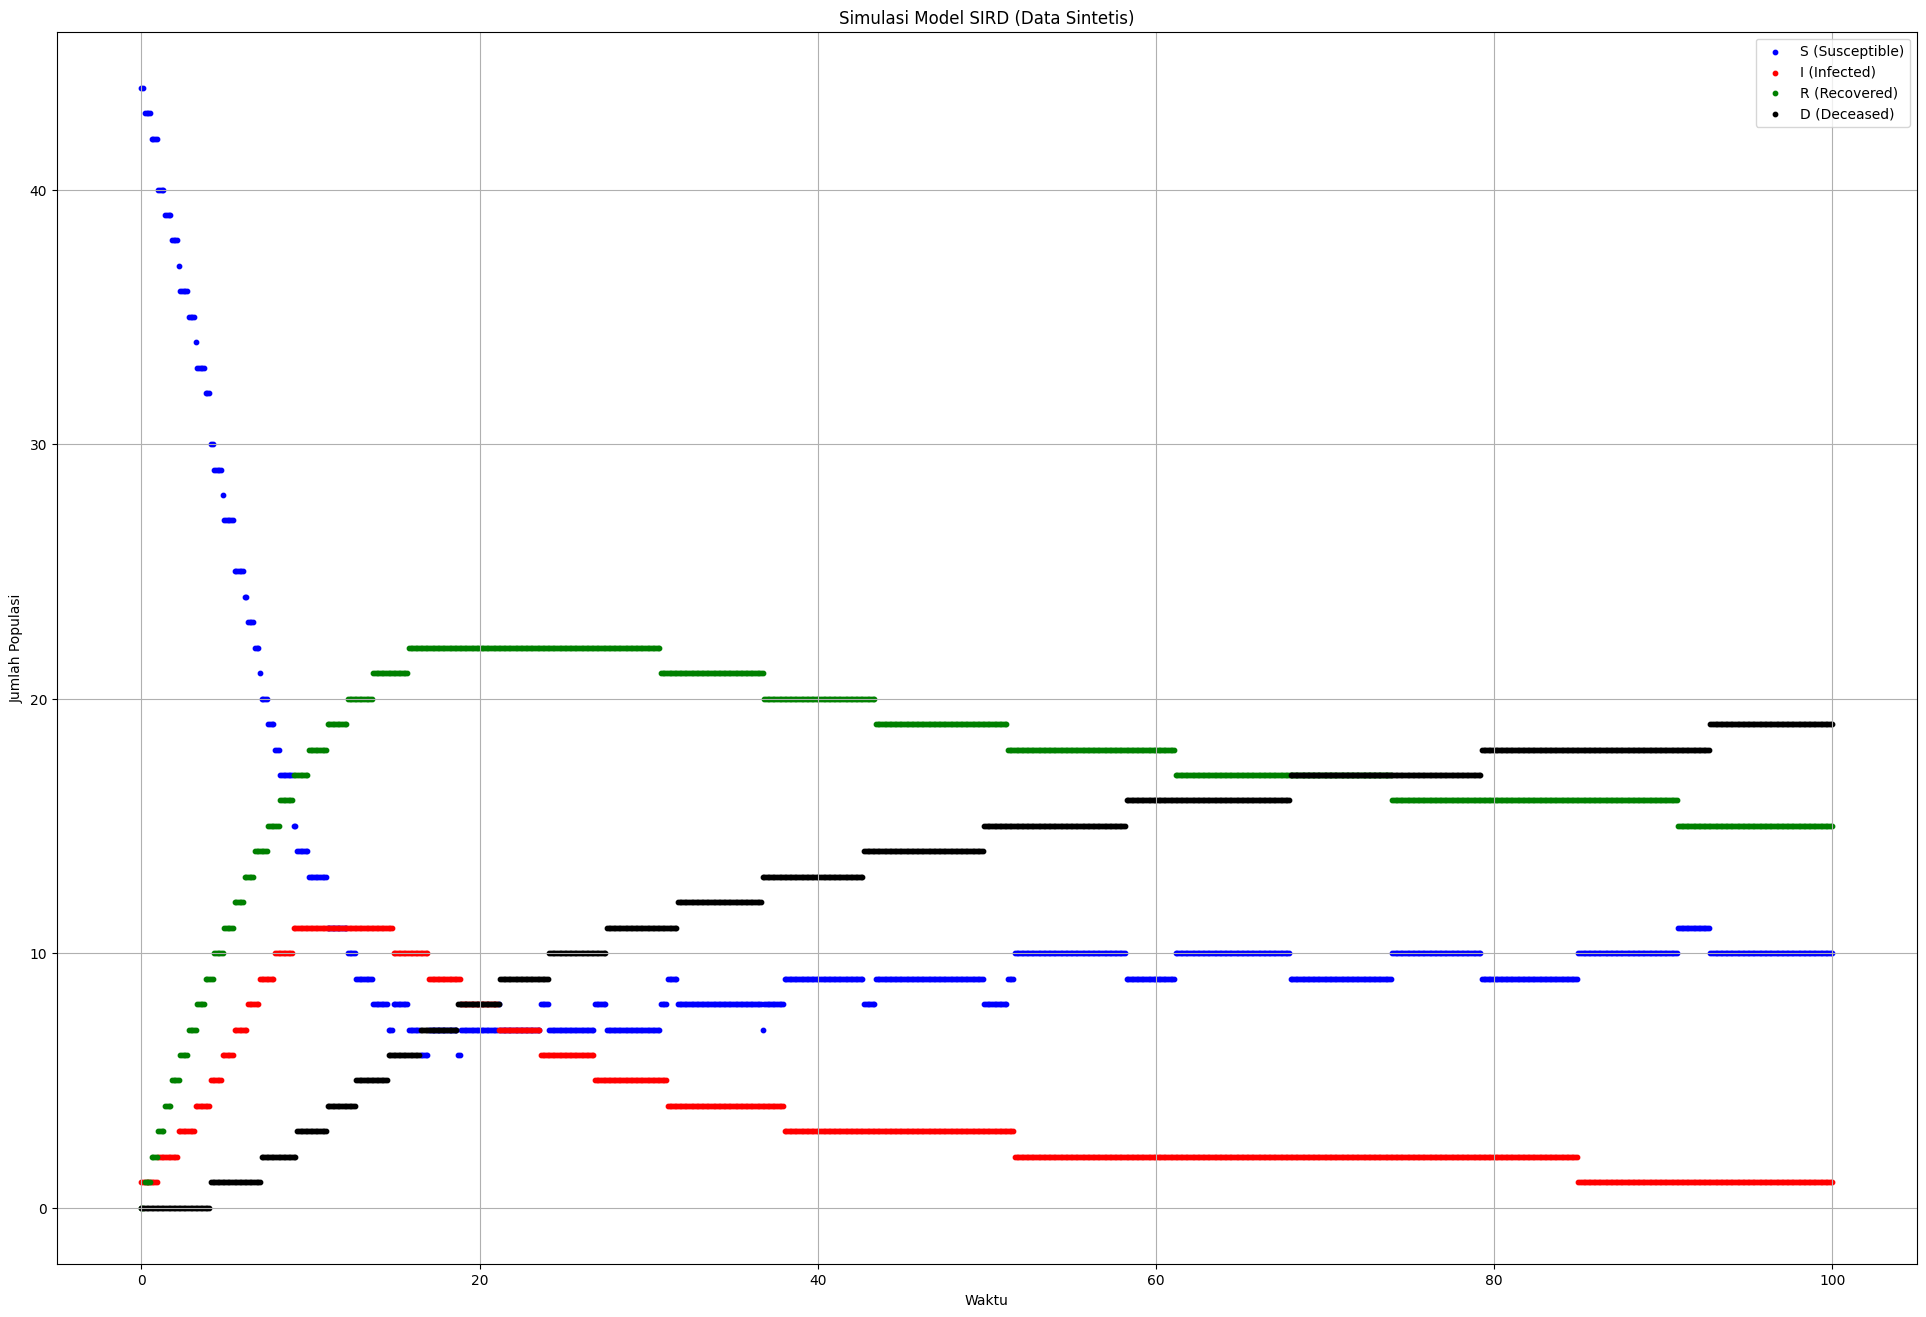

In [37]:
plt.figure(figsize=(24, 16))
plt.scatter(t, S_int, label='S (Susceptible)', color='blue', s=10)
plt.scatter(t, I_int, label='I (Infected)', color='red', s=10)
plt.scatter(t, R_int, label='R (Recovered)', color='green', s=10)
plt.scatter(t, D_int, label='D (Deceased)', color='black', s=10)
plt.xlabel('Waktu')
plt.ylabel('Jumlah Populasi')
plt.title('Simulasi Model SIRD (Data Sintetis)')
plt.legend()
plt.grid(True)
plt.show()

## Fitting Data

### Fungsi fitting data

In [38]:
def sird_fit(t_single, alpha, beta, gamma, mu, delta, p):
    t_array = np.linspace(0, t_single, 100)
    solution = odeint(sird_model, y0, t_array, args=(N, alpha, beta, gamma, mu, delta, p))
    return solution[-1] # parameter pada waktu terakhir 

### Baca file dataset untuk di fitting

In [39]:
data_fitting = pd.read_csv('dataset.csv')
t_data = data_fitting['time'].values
S_data = data_fitting['S'].values
I_data = data_fitting['I'].values
R_data = data_fitting['R'].values
D_data = data_fitting['D'].values

### Modifikasi Fungsi Fit untuk curve

In [40]:
def sird_fit_wrapper(t, alpha, beta, gamma, mu, delta, p):
    results = np.zeros((len(t), 4))
    for i, t_val in enumerate(t):
        results[i] = sird_fit(t_val, alpha, beta, gamma, mu, delta, p)
    return results.flatten()

### Membuat array 1D dari dataset dan membuat tebakan parameter 

In [41]:
data_combined = np.column_stack((S_data, I_data, R_data, D_data)).flatten()

### Melakukan Fitting dengan fungsi curve_fit

In [42]:
params, params_covariance = curve_fit(
    sird_fit_wrapper, t_data, data_combined, 
    p0=initial_guess, 
    maxfev=10000,
    bounds=([0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1])
)

### Menampilkan parameter hasil fitting

In [43]:
fitted_alpha, fitted_beta, fitted_gamma, fitted_mu, fitted_delta, fitted_p = params
print("\nParameter hasil fitting:")
print(f"Alpha: {fitted_alpha:.4f}")
print(f"Beta: {fitted_beta:.4f}")
print(f"Gamma: {fitted_gamma:.4f}")
print(f"Mu: {fitted_mu:.4f}")
print(f"Delta: {fitted_delta:.4f}")
print(f"P: {fitted_p:.4f}")


Parameter hasil fitting:
Alpha: 0.1987
Beta: 0.9003
Gamma: 0.0998
Mu: 0.0502
Delta: 0.0503
P: 0.6965


### Simulasi ulang dengan parameter hasil fitting menggunakan odeint

In [44]:
solution_fitted = odeint(sird_model, y0, t, args=(N, fitted_alpha, fitted_beta, fitted_gamma, fitted_mu, fitted_delta, fitted_p))
S_fitted, I_fitted, R_fitted, D_fitted = solution_fitted.T

### Visualisasi Hasil Fitting

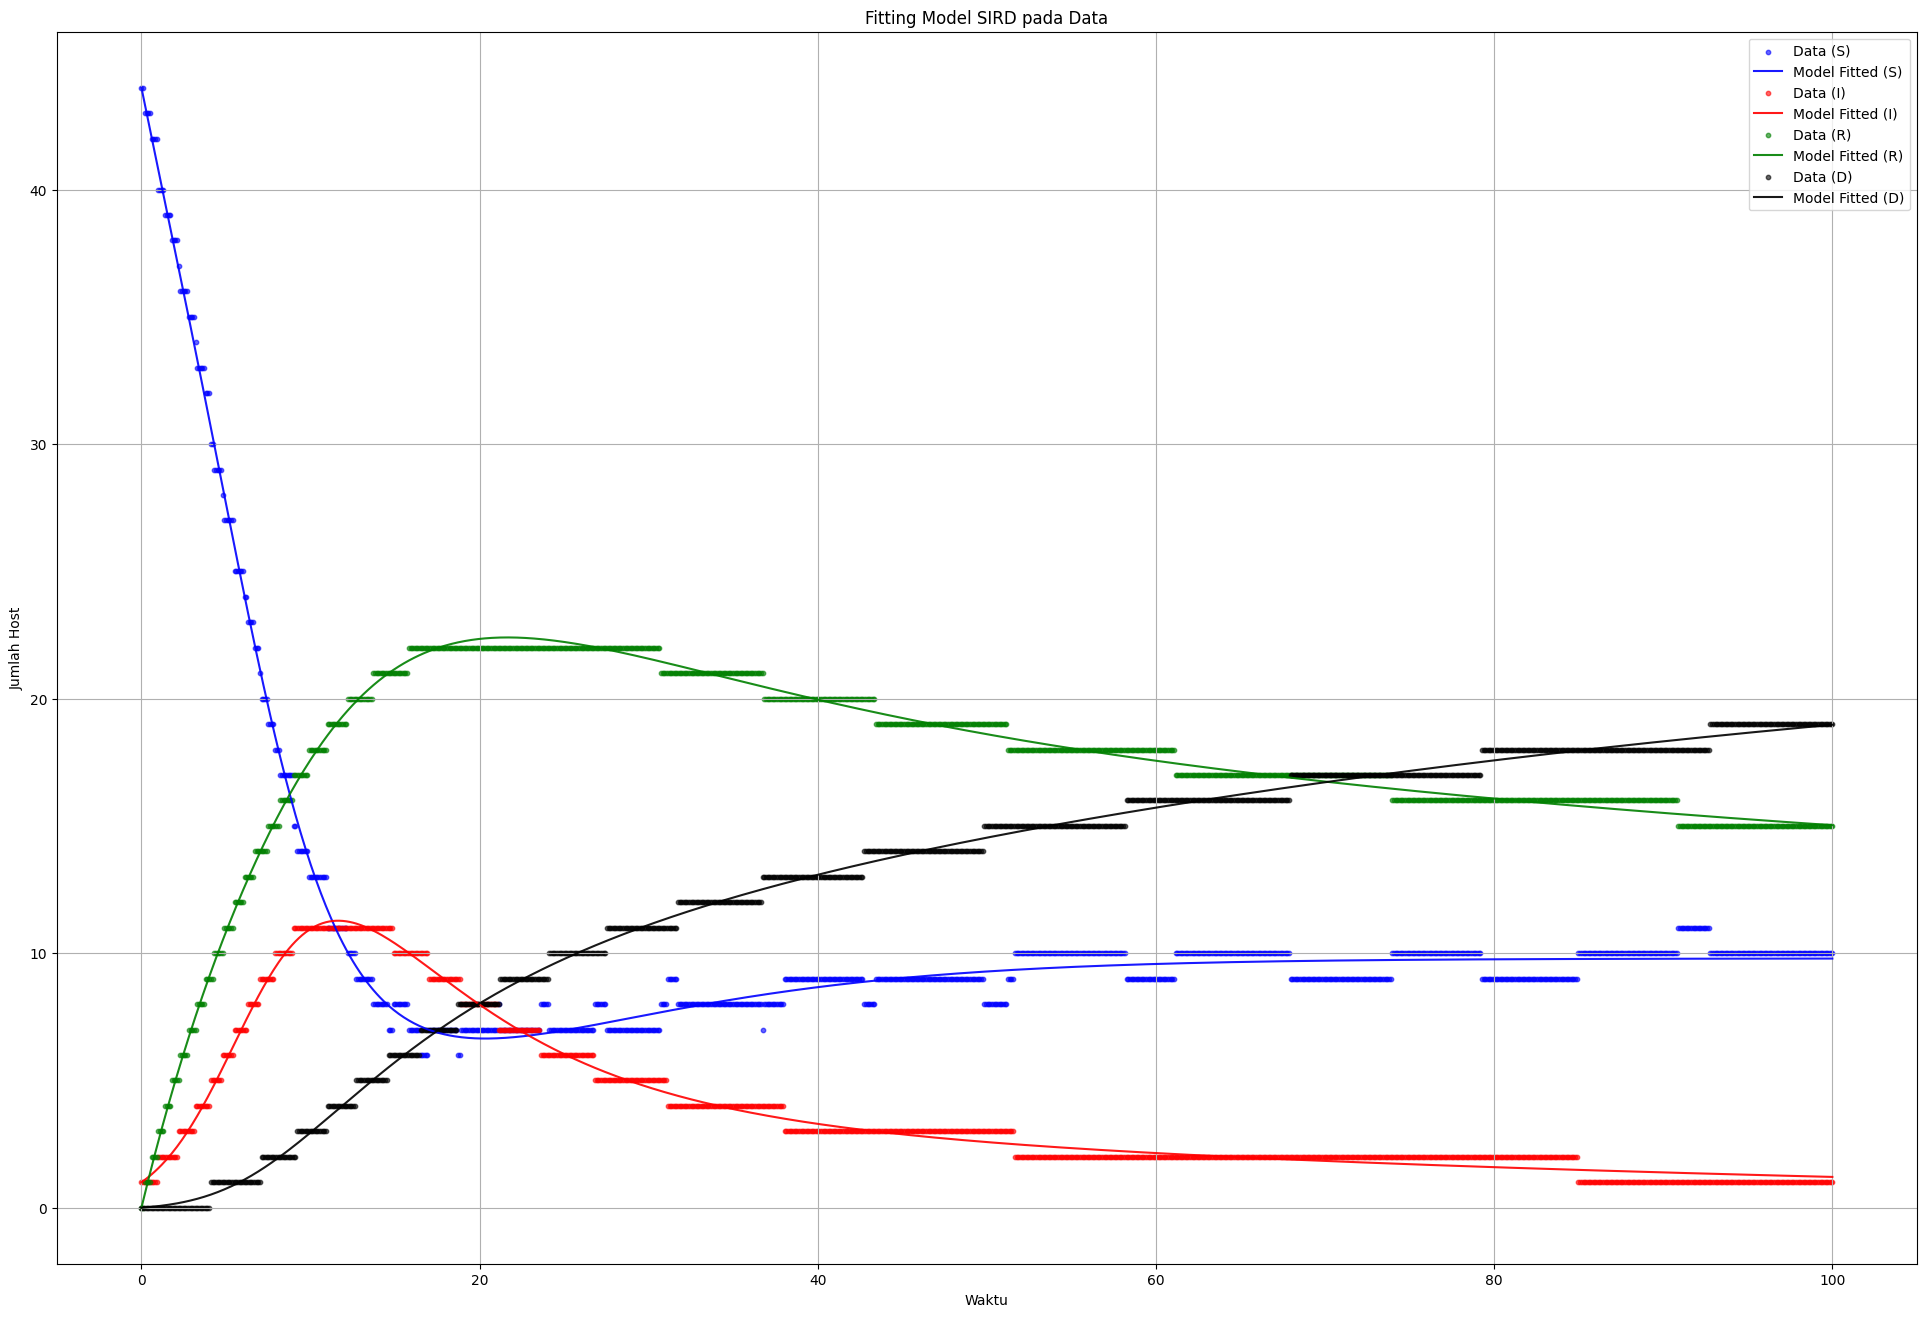

In [45]:
plt.figure(figsize=(24, 16))
plt.scatter(t_data, S_data, color='blue', label='Data (S)', s=10, alpha=0.6)
plt.plot(t, S_fitted, 'b', label='Model Fitted (S)', alpha=0.9)

plt.scatter(t_data, I_data, color='red', label='Data (I)', s=10, alpha=0.6)
plt.plot(t, I_fitted, 'r', label='Model Fitted (I)', alpha=0.9)

plt.scatter(t_data, R_data, color='green', label='Data (R)', s=10, alpha=0.6)
plt.plot(t, R_fitted, 'g', label='Model Fitted (R)', alpha=0.9)

plt.scatter(t_data, D_data, color='black', label='Data (D)', s=10, alpha=0.6)
plt.plot(t, D_fitted, 'k', label='Model Fitted (D)', alpha=0.9)

plt.xlabel('Waktu')
plt.ylabel('Jumlah Host')
plt.title('Fitting Model SIRD pada Data')
plt.legend()
plt.grid(True)
plt.show()